# Building a Native-Space Structural Connectome in Native Space Using Tensor Model with Deterministic Tractography
## Derek Pisner
## 4/21/2019

In [3]:
# Universal imports
import pylab
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np
import networkx as nx
import warnings
warnings.simplefilter("ignore")
pylab.rcParams['figure.figsize'] = 24, 14
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 16}
from fury import actor, window, colormap as cmap

# Load and Prepare the Data 

In [4]:
# From local directory
# Assumes sampledmriconnectome repository has been downloaded from 
# github and jupyter notebook has been started from within that directory
dwi_img = nib.load('dwi_prep_reor.nii.gz')
fbval = 'bval.bval'
fbvec = 'bvecs_reor.bvec'
img_pve_wm = nib.load('t1w_wm_in_dwi.nii.gz')
img_wm_gm_int = nib.load('t1w_wm_gm_int_in_dwi.nii.gz')
t1w_in_dwi_img = nib.load('t1w_in_dwi.nii.gz')
mean_B0_img = nib.load('nodif_B0_bet.nii.gz')
labels_img = nib.load('desikan_space-MNI152NLin6_res-2x2x2_aligned_atlas_dwi.nii.gz')

In [5]:
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

# Make gradient table (gtab) from bval/bvec
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
# Creating the gradient table
gtab = gradient_table(bvals, bvecs)

# Correct b0 threshold
gtab.b0_threshold = min(bvals)

# Get b0 indices
b0s = np.where(gtab.bvals == gtab.b0_threshold)[0]
print("%s%s" % ('b0\'s found at: ', b0s))

print('bvals: \n' + str(gtab.bvals))

print('bvecs: \n' + str(gtab.bvecs))

b0's found at: [  0  16  32  48  64  80  96 112 128]
bvals: 
[   0. 1500. 1495. 1495. 1500. 1500. 1500. 1505. 1500. 1505. 1500. 1500.
 1500. 1500. 1495. 1505.    0. 1495. 1495. 1495. 1495. 1505. 1505. 1495.
 1500. 1495. 1495. 1495. 1500. 1500. 1505. 1505.    0. 1505. 1500. 1500.
 1500. 1495. 1500. 1500. 1500. 1495. 1500. 1500. 1500. 1505. 1505. 1495.
    0. 1500. 1500. 1495. 1500. 1500. 1495. 1495. 1495. 1500. 1500. 1500.
 1500. 1500. 1505. 1500.    0. 1505. 1495. 1505. 1505. 1505. 1500. 1495.
 1500. 1500. 1500. 1500. 1505. 1500. 1500. 1500.    0. 1495. 1500. 1505.
 1495. 1505. 1505. 1500. 1495. 1495. 1495. 1500. 1500. 1505. 1505. 1505.
    0. 1505. 1500. 1500. 1500. 1500. 1500. 1495. 1500. 1505. 1505. 1495.
 1505. 1500. 1505. 1495.    0. 1495. 1495. 1505. 1500. 1500. 1505. 1505.
 1495. 1500. 1505. 1500. 1500. 1500. 1505. 1500.    0. 1495. 1505. 1495.
 1495. 1500. 1495. 1495. 1505.]
bvecs: 
[[ 0.          0.          0.        ]
 [ 0.999998   -0.          0.00199999]
 [-0.5569347   0.5

# Build a Binary White-Matter Tissue Classifier

In [6]:
from dipy.tracking.local import BinaryTissueClassifier

tissue_classifier = BinaryTissueClassifier(img_pve_wm.get_data() > 0)

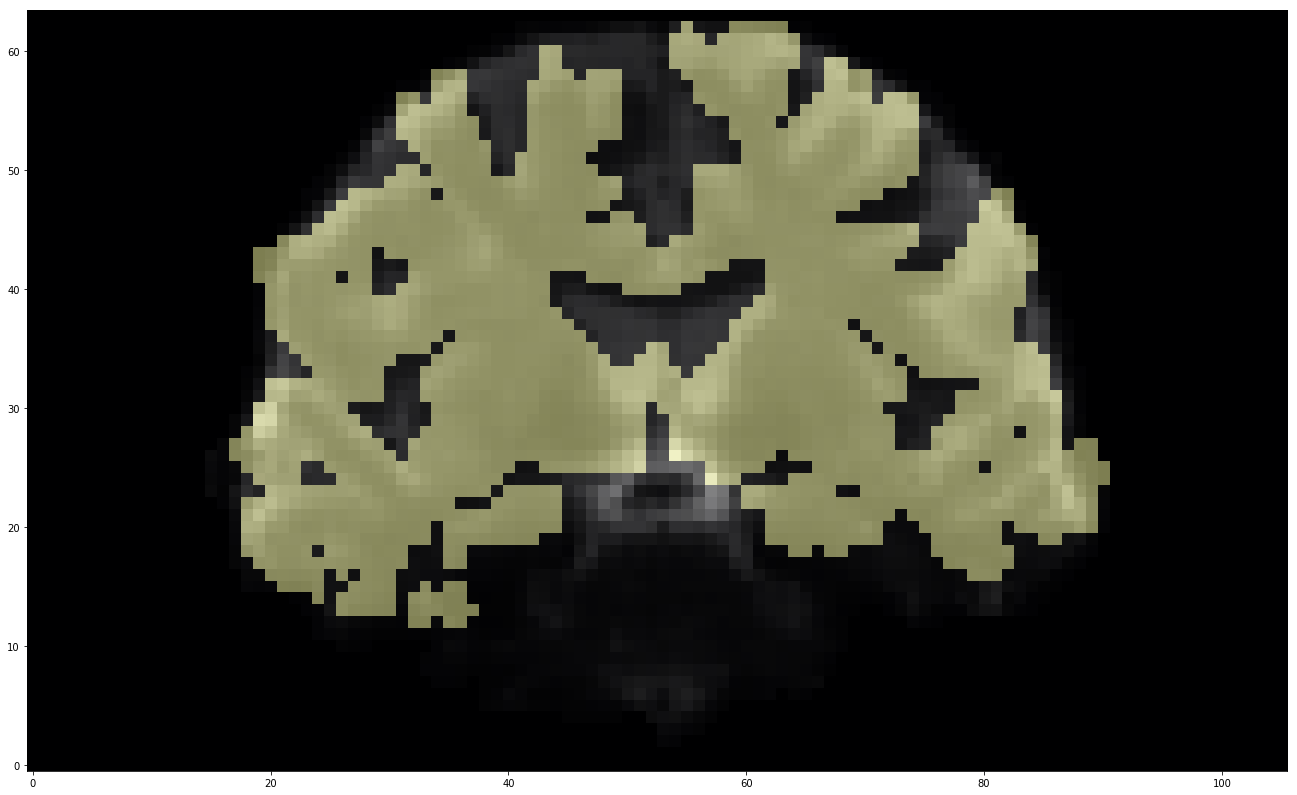

In [7]:
mask = img_pve_wm.get_data()[:,50,:] > 0
b0 = np.copy(mean_B0_img.get_data()[:,50,:].astype("float32"))

plt.imshow(b0.T,cmap='gray', origin="lower",)
plt.imshow(mask.T, cmap='inferno', origin="lower", alpha=.5)
plt.show()

# Seeding

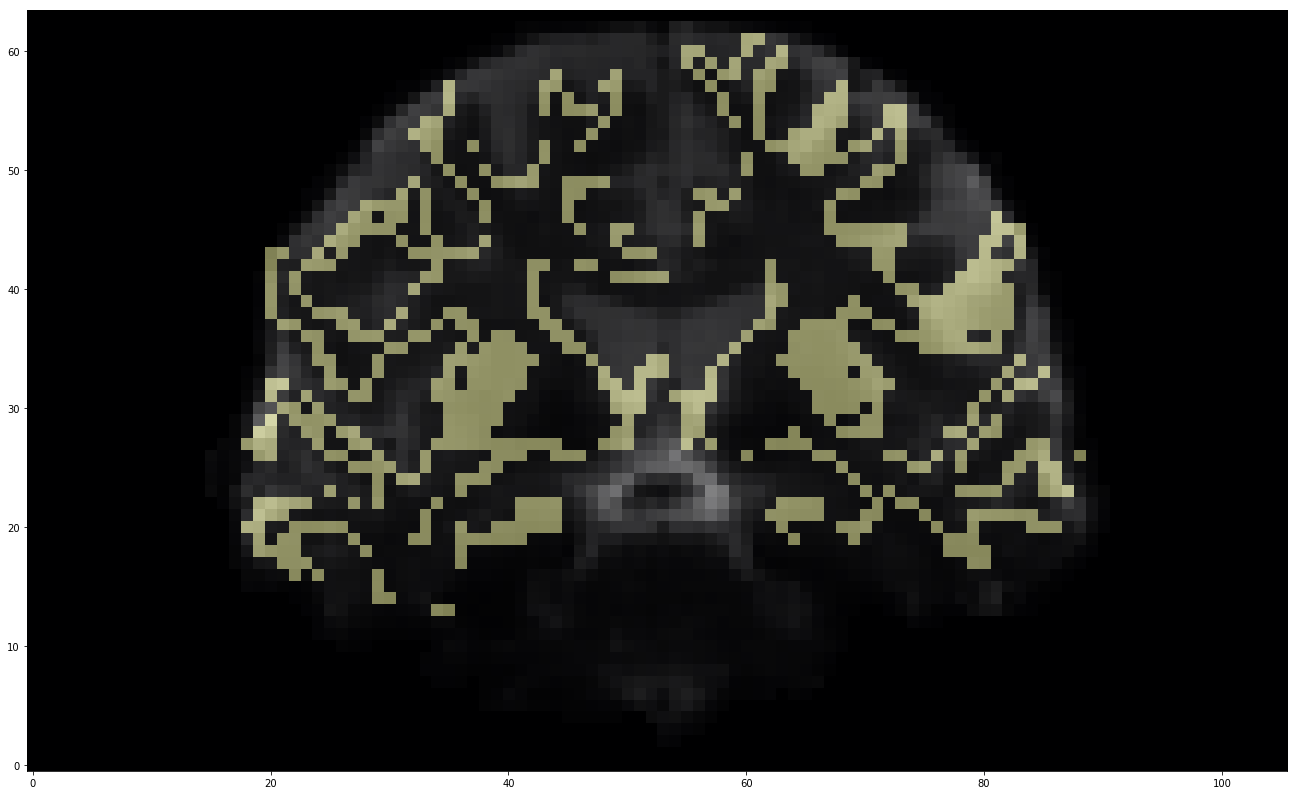

DONE


In [8]:
# Visualize White-Matter - Grey Matter Interface from which we will be seeding
mask = img_wm_gm_int.get_data()[:,50,:] > 0
b0 = np.copy(mean_B0_img.get_data()[:,50,:].astype("float32"))

plt.imshow(b0.T,cmap='gray', origin="lower",)
plt.imshow(mask.T, cmap='inferno', origin="lower", alpha=.5)
plt.show()

def build_seed_list(mask_img, dens=1):
    from dipy.tracking import utils
    mask_img_data = mask_img.get_data().astype('bool')
    seeds = utils.random_seeds_from_mask(mask_img_data, seeds_count=int(dens), 
                                         seed_count_per_voxel=True,
                                         affine=np.eye(4))
    return seeds

seeds = build_seed_list(img_wm_gm_int)
print('DONE')

In [9]:
print(seeds)

[[65.73744243  8.84749912 30.65179767]
 [47.06168398 19.61293155 32.42340721]
 [40.46222211  9.49466941 27.86783873]
 ...
 [34.62784649 12.75755078 35.18660557]
 [71.04759713 31.15599884  7.94740348]
 [46.52665648 76.41979365 35.97992474]]


# Fit simple tensor model

In [10]:
from dipy.data import get_sphere
from dipy.reconst.dti import TensorModel
from dipy.reconst.dti import fractional_anisotropy
    
def tens_mod_fa_est(gtab, dwi_img, mean_B0_img):
    data = dwi_img.get_data()

    print('Fitting tensor model...')
    B0_mask = mean_B0_img.get_data().astype('bool')
    B0_affine = mean_B0_img.affine
    model = TensorModel(gtab)
    mod = model.fit(data, B0_mask)
    print('Computing anisotropy measures (FA, MD, RGB)')
    FA = fractional_anisotropy(mod.evals)
    FA[np.isnan(FA)] = 0
    fa_img = nib.Nifti1Image(FA.astype(np.float32), B0_affine)
    nib.save(fa_img, 'tensor_fa.nii.gz')
    return fa_img, FA, model, mod 

[fa_img, FA, model, mod] = tens_mod_fa_est(gtab, dwi_img, mean_B0_img)

sphere = get_sphere('repulsion724')
print('DONE')

Fitting tensor model...
Computing anisotropy measures (FA, MD, RGB)
DONE


In [51]:
# Visualize FA image
import fury
from dipy.viz import window, actor, ui
from dipy.reconst.dti import color_fa

r = window.Renderer()
r.clear()
RGB = color_fa(FA, mod.evecs)
cfa = RGB
cfa /= cfa.max()
fa_actor = actor.tensor_slicer(mod.evals, mod.evecs, scalar_colors=cfa, sphere=sphere, scale=0.5)
r.add(fa_actor)

window.record(r, out_path='tensor_FA.png', size=(600, 600))
window.show(r)

# Get Peak Directions for Each Voxel Based on Tensor Model

In [12]:
from dipy.reconst.peaks import peaks_from_model

print('Grabbing peak directions from model...')
print('*This step takes a few minutes*')
dti_dg = peaks_from_model(model=model, 
                          data=dwi_img.get_data(), 
                          sphere=sphere, 
                          relative_peak_threshold=.5, 
                          min_separation_angle=25, 
                          normalize_peaks=True, 
                          mask = img_pve_wm.get_data(), 
                          npeaks=5)
print('DONE')

This step takes a few minutes...
DONE


# Perform tractography

In [13]:
from dipy.tracking.local import LocalTracking
from dipy.tracking.streamline import Streamlines

min_length = 60
streamline_generator = LocalTracking(dti_dg, 
                                     tissue_classifier, 
                                     seeds, 
                                     np.eye(4), 
                                     step_size=.5)
streamlines = Streamlines(streamline_generator)
tracks = Streamlines([s for s in streamlines if len(s) > min_length])
print('DONE')

DONE


In [49]:
r = window.Renderer()
r.clear()
image_actor_z = actor.slicer(t1w_in_dwi_img.get_data())
r.add(image_actor_z)
image_actor_x = image_actor_z.copy()
x_midpoint = int(np.round(t1w_in_dwi_img.shape[0] / 2))
image_actor_x.display_extent(x_midpoint,
                             x_midpoint, 0,
                             t1w_in_dwi_img.shape[1] - 1,
                             0,
                             t1w_in_dwi_img.shape[2] - 1)
r.add(image_actor_x)
r.add(actor.line(streamlines, cmap.line_colors(streamlines)))
window.record(r, out_path='tractogram.png', size=(600, 600))
window.show(r)

# Build Connectivity Matrix Using Native-Space Labels

In [14]:
# Warning: this is purely for the sake of demonstration on an individual subject level. 
# In practice, structural connectivity matrices require that the underlying data be 
# normalized (i.e. ideally morphologically by mapping streamlines to a common template)
def make_graph(tracks, rois):
    from itertools import combinations
    from collections import defaultdict
    
    print('Building connectivity matrix...')
    edge_dict = defaultdict(int)
    n_ids = np.unique(rois)
    n_ids = n_ids[n_ids > 0]
    N = len(n_ids)
    g = nx.Graph()
    print(g.graph)

    [g.add_node(ids) for ids in n_ids]

    nlines = np.shape(tracks)[0]
    print("Streamline Count: " + str(nlines))

    for idx, streamline in enumerate(tracks):
        if (idx % int(nlines * 0.05)) == 0:
            print(idx)

        points = np.round(streamline).astype(int)
        p = set()
        for point in points:
            try:
                loc = rois[point[0], point[1], point[2]]
            except IndexError:
                loc = ""
                pass

            if loc:
                p.add(loc)
            else:
                pass

        edges = combinations(p, 2)
        for edge in edges:
            lst = tuple([int(node) for node in edge])
            edge_dict[tuple(sorted(lst))] += 1

    edge_list = [(k[0], k[1], v) for k, v in list(edge_dict.items())]
    g.add_weighted_edges_from(edge_list)
    
    return g, edge_dict


rois = labels_img.get_data().astype('int')

[g, edge_dict] = make_graph(tracks, rois)
print('DONE')

Building connectivity matrix...
{}
Streamline Count: 18429
0
921
1842
2763
3684
4605
5526
6447
7368
8289
9210
10131
11052
11973
12894
13815
14736
15657
16578
17499
18420
DONE


In [18]:
print(edge_dict)

defaultdict(<class 'int'>, {(1, 4): 670, (1, 11): 1718, (1, 17): 1615, (1, 18): 1709, (1, 24): 1458, (1, 25): 1840, (1, 26): 3055, (1, 29): 1068, (4, 11): 69, (4, 17): 367, (4, 18): 278, (4, 24): 513, (4, 25): 603, (4, 26): 243, (4, 29): 774, (11, 17): 396, (11, 18): 108, (11, 24): 384, (11, 25): 113, (11, 26): 1778, (11, 29): 130, (17, 18): 853, (17, 24): 838, (17, 25): 743, (17, 26): 801, (17, 29): 528, (18, 24): 1140, (18, 25): 1420, (18, 26): 588, (18, 29): 603, (24, 25): 849, (24, 26): 683, (24, 29): 744, (25, 26): 508, (25, 29): 725, (26, 29): 460, (1, 32): 1632, (25, 32): 823, (23, 32): 1133, (1, 23): 1258, (23, 25): 1491, (2, 32): 1035, (9, 32): 1678, (16, 32): 441, (30, 32): 2201, (2, 9): 2311, (2, 16): 1528, (2, 30): 1609, (9, 16): 1470, (9, 30): 3039, (16, 30): 988, (1, 5): 1671, (1, 9): 1375, (1, 13): 1492, (1, 20): 243, (1, 30): 2248, (1, 31): 1420, (1, 35): 732, (1, 36): 2339, (1, 40): 1179, (1, 44): 695, (1, 46): 1611, (1, 52): 706, (1, 61): 1729, (1, 65): 1250, (1, 66):

/usr/local/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


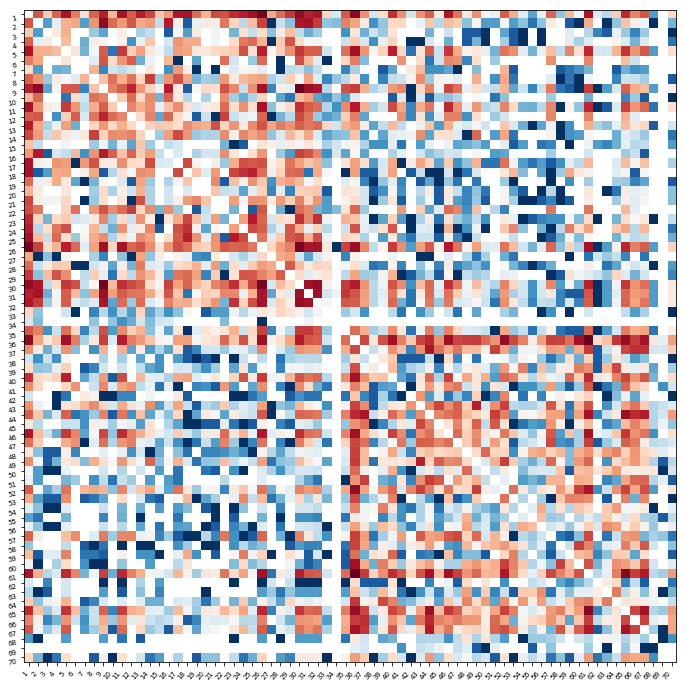

In [19]:
from nilearn import plotting

# Convert to numpy matrix
conn_matrix = nx.to_numpy_matrix(g)

# Enforce symmetry
conn_matrix_symm = np.maximum(conn_matrix, conn_matrix.T)

# Zero diagonal
np.fill_diagonal(conn_matrix_symm, 0)

# Log transform graph
conn_matrix_symm = np.log10(conn_matrix_symm)

# Plot
plotting.plot_matrix(conn_matrix_symm, labels=np.unique(rois)[1:], figure=(12, 12), colorbar=False)

# Save matrix
np.save('conn_matrix.npy', conn_matrix_symm)

In [30]:
# Collapse list of connected streamlines for visualization
from dipy.tracking.streamline import select_by_rois
parcels = []
i = 0
for roi in np.unique(rois)[1:]:
    parcels.append(rois==roi)
    i = i + 1

streamlines_viz = Streamlines(select_by_rois(streamlines, parcels, np.ones(len(parcels)), mode='both_end', affine=np.eye(4), tol=None))
print('DONE')

DONE


In [31]:
streamlines_viz 

ArraySequence([array([[62.43484416,  6.73913565, 30.91146808],
       [62.83554004,  7.0050074 , 31.04841707],
       [63.24143796,  7.28613736, 31.1272385 ],
       [63.64939894,  7.5751515 , 31.12101996],
       [64.06186898,  7.8507533 , 31.05847303],
       [64.49129052,  8.09544551, 30.98282344],
       [64.93551891,  8.30841739, 30.89735936],
       [65.35950957,  8.54966822, 30.78767817],
       [65.73744243,  8.84749912, 30.65179767],
       [66.11537528,  9.14533002, 30.51591718],
       [66.43911815,  9.49236629, 30.35857556],
       [66.74101951,  9.8647594 , 30.21652297],
       [66.99830437, 10.27366719, 30.08768617],
       [67.20237036, 10.71147123, 29.95851692],
       [67.39402289, 11.14959328, 29.81250879],
       [67.58295576, 11.58372489, 29.65177884],
       [67.75513463, 12.01954537, 29.47738001],
       [67.90831348, 12.45470286, 29.28457391],
       [68.04598103, 12.88883657, 29.07823543],
       [68.17826375, 13.31912336, 28.8606244 ],
       [68.28595831, 13.7

In [46]:
# Visualize glass brain connectome
from dipy.tracking.streamline import Streamlines
import random


streamlines_viz = [s for s in streamlines_viz if len(s) > 100]
r = window.Renderer()
r.add(actor.line(Streamlines(streamlines_viz), cmap.create_colormap(np.ones([len(streamlines_viz)]), name='Greys_r', auto=True), lod_points=10000, depth_cue=True, linewidth=0.2, fake_tube=True))

roi_colors = np.random.rand(int(np.max(rois)), 3)
parcel_contours = []
i = 0

rois_disp = np.unique(rois)[1:36]

for roi in rois_disp:
    parcel_contours.append(actor.contour_from_roi(rois==roi, color=roi_colors[i], opacity=0.2))
    i = i + 1

for vol_actor in parcel_contours:
    r.add(vol_actor)

t1w_in_dwi_img_data = t1w_in_dwi_img.get_data().astype('bool')
t1w_in_dwi_actor = actor.contour_from_roi(t1w_in_dwi_img_data, color=(50, 50, 50), opacity=0.01)
r.add(t1w_in_dwi_actor)

window.record(r, out_path='glass_brain.png', size=(600, 600))
window.show(r)